# Problem : Linear Calibration (Thermometer)

- **Task:** Map “unknown-scale” readings $t_u$ to true Celsius $t_c$ using a simple nn.Sequential model.

# Imports

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

print(sys.version)
print(torch.__version__)
print(np.__version__)

3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:28:53) [Clang 19.1.7 ]
2.8.0
2.3.4


# Dataset

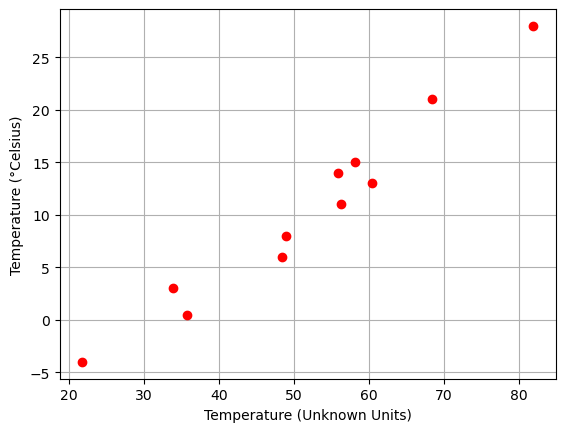

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o', color='red')
plt.xlabel('Temperature (Unknown Units)')
plt.ylabel('Temperature (°Celsius)')
plt.show()

In [3]:
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1) 

t_c.shape, t_u.shape

/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66248/4186579624.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_c = torch.tensor(t_c).unsqueeze(1)
/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66248/4186579624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_u = torch.tensor(t_u).unsqueeze(1)


(torch.Size([11, 1]), torch.Size([11, 1]))

# Nonmalization

In [4]:
normalization_factor = 0.1

In [5]:
t_u *= normalization_factor
t_c *= normalization_factor

# Model - Using nn.Sequential



In [6]:
import torch.nn as nn
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 13)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(13, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

# Loss Function - torch.nn.MSELoss


$$
L(yp,y)=\frac{1}{N}\sum_{i=1}^{N}\Big(yp^{(i)}-y^{(i)}\Big)^2
$$

&emsp;&emsp;&emsp;yp : Predicted values.<br>
&emsp;&emsp;&emsp;y  : Acutal Values.




In [7]:
loss_fn = nn.MSELoss()

# Backword Propogation Gradients - using torch.optim.SGD

Using pytorch SGD optimizer to perform backword propagation and paramert updations.


In [8]:
import torch.optim as optim
learning_rate = 1e-2
optimizer = optim.SGD(seq_model.parameters(), lr=learning_rate)

# Gradient Descent Training Loop 


In [9]:
def training_loop(n_epochs, optimizer, model, loss_fn, x, y, print_params=True):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                params = list(model.named_parameters())
                print('    Params:', params)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break

    return params

In [10]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = loss_fn,
    x = t_u,
    y = t_c)

params = list(seq_model.parameters())
print('Learned parameters:', params)

/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66248/824654950.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1760285604563/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('Epoch %d, Loss %f' % (epoch, float(loss)))


Epoch 1, Loss 0.711267
    Params: [('hidden_linear.weight', Parameter containing:
tensor([[ 0.0683],
        [-0.3728],
        [ 0.2807],
        [-0.3535],
        [ 0.5824],
        [ 0.1100],
        [ 0.4033],
        [-0.2921],
        [-0.5184],
        [-0.8676],
        [ 0.1583],
        [ 0.5344],
        [ 0.4015]], requires_grad=True)), ('hidden_linear.bias', Parameter containing:
tensor([ 0.6305, -0.4918, -0.1677, -0.9388,  0.4924, -0.5284,  0.6400, -0.6920,
         0.3282,  0.6420, -0.1458, -0.1299,  0.9418], requires_grad=True)), ('output_linear.weight', Parameter containing:
tensor([[ 0.1446,  0.0636,  0.2496,  0.1122,  0.0632,  0.2145,  0.1622,  0.0764,
         -0.1025,  0.1863,  0.0645,  0.1551,  0.2521]], requires_grad=True)), ('output_linear.bias', Parameter containing:
tensor([0.1954], requires_grad=True))]
Epoch 2, Loss 0.655561
    Params: [('hidden_linear.weight', Parameter containing:
tensor([[ 0.0703],
        [-0.3729],
        [ 0.2804],
        [-0.3536

# Output

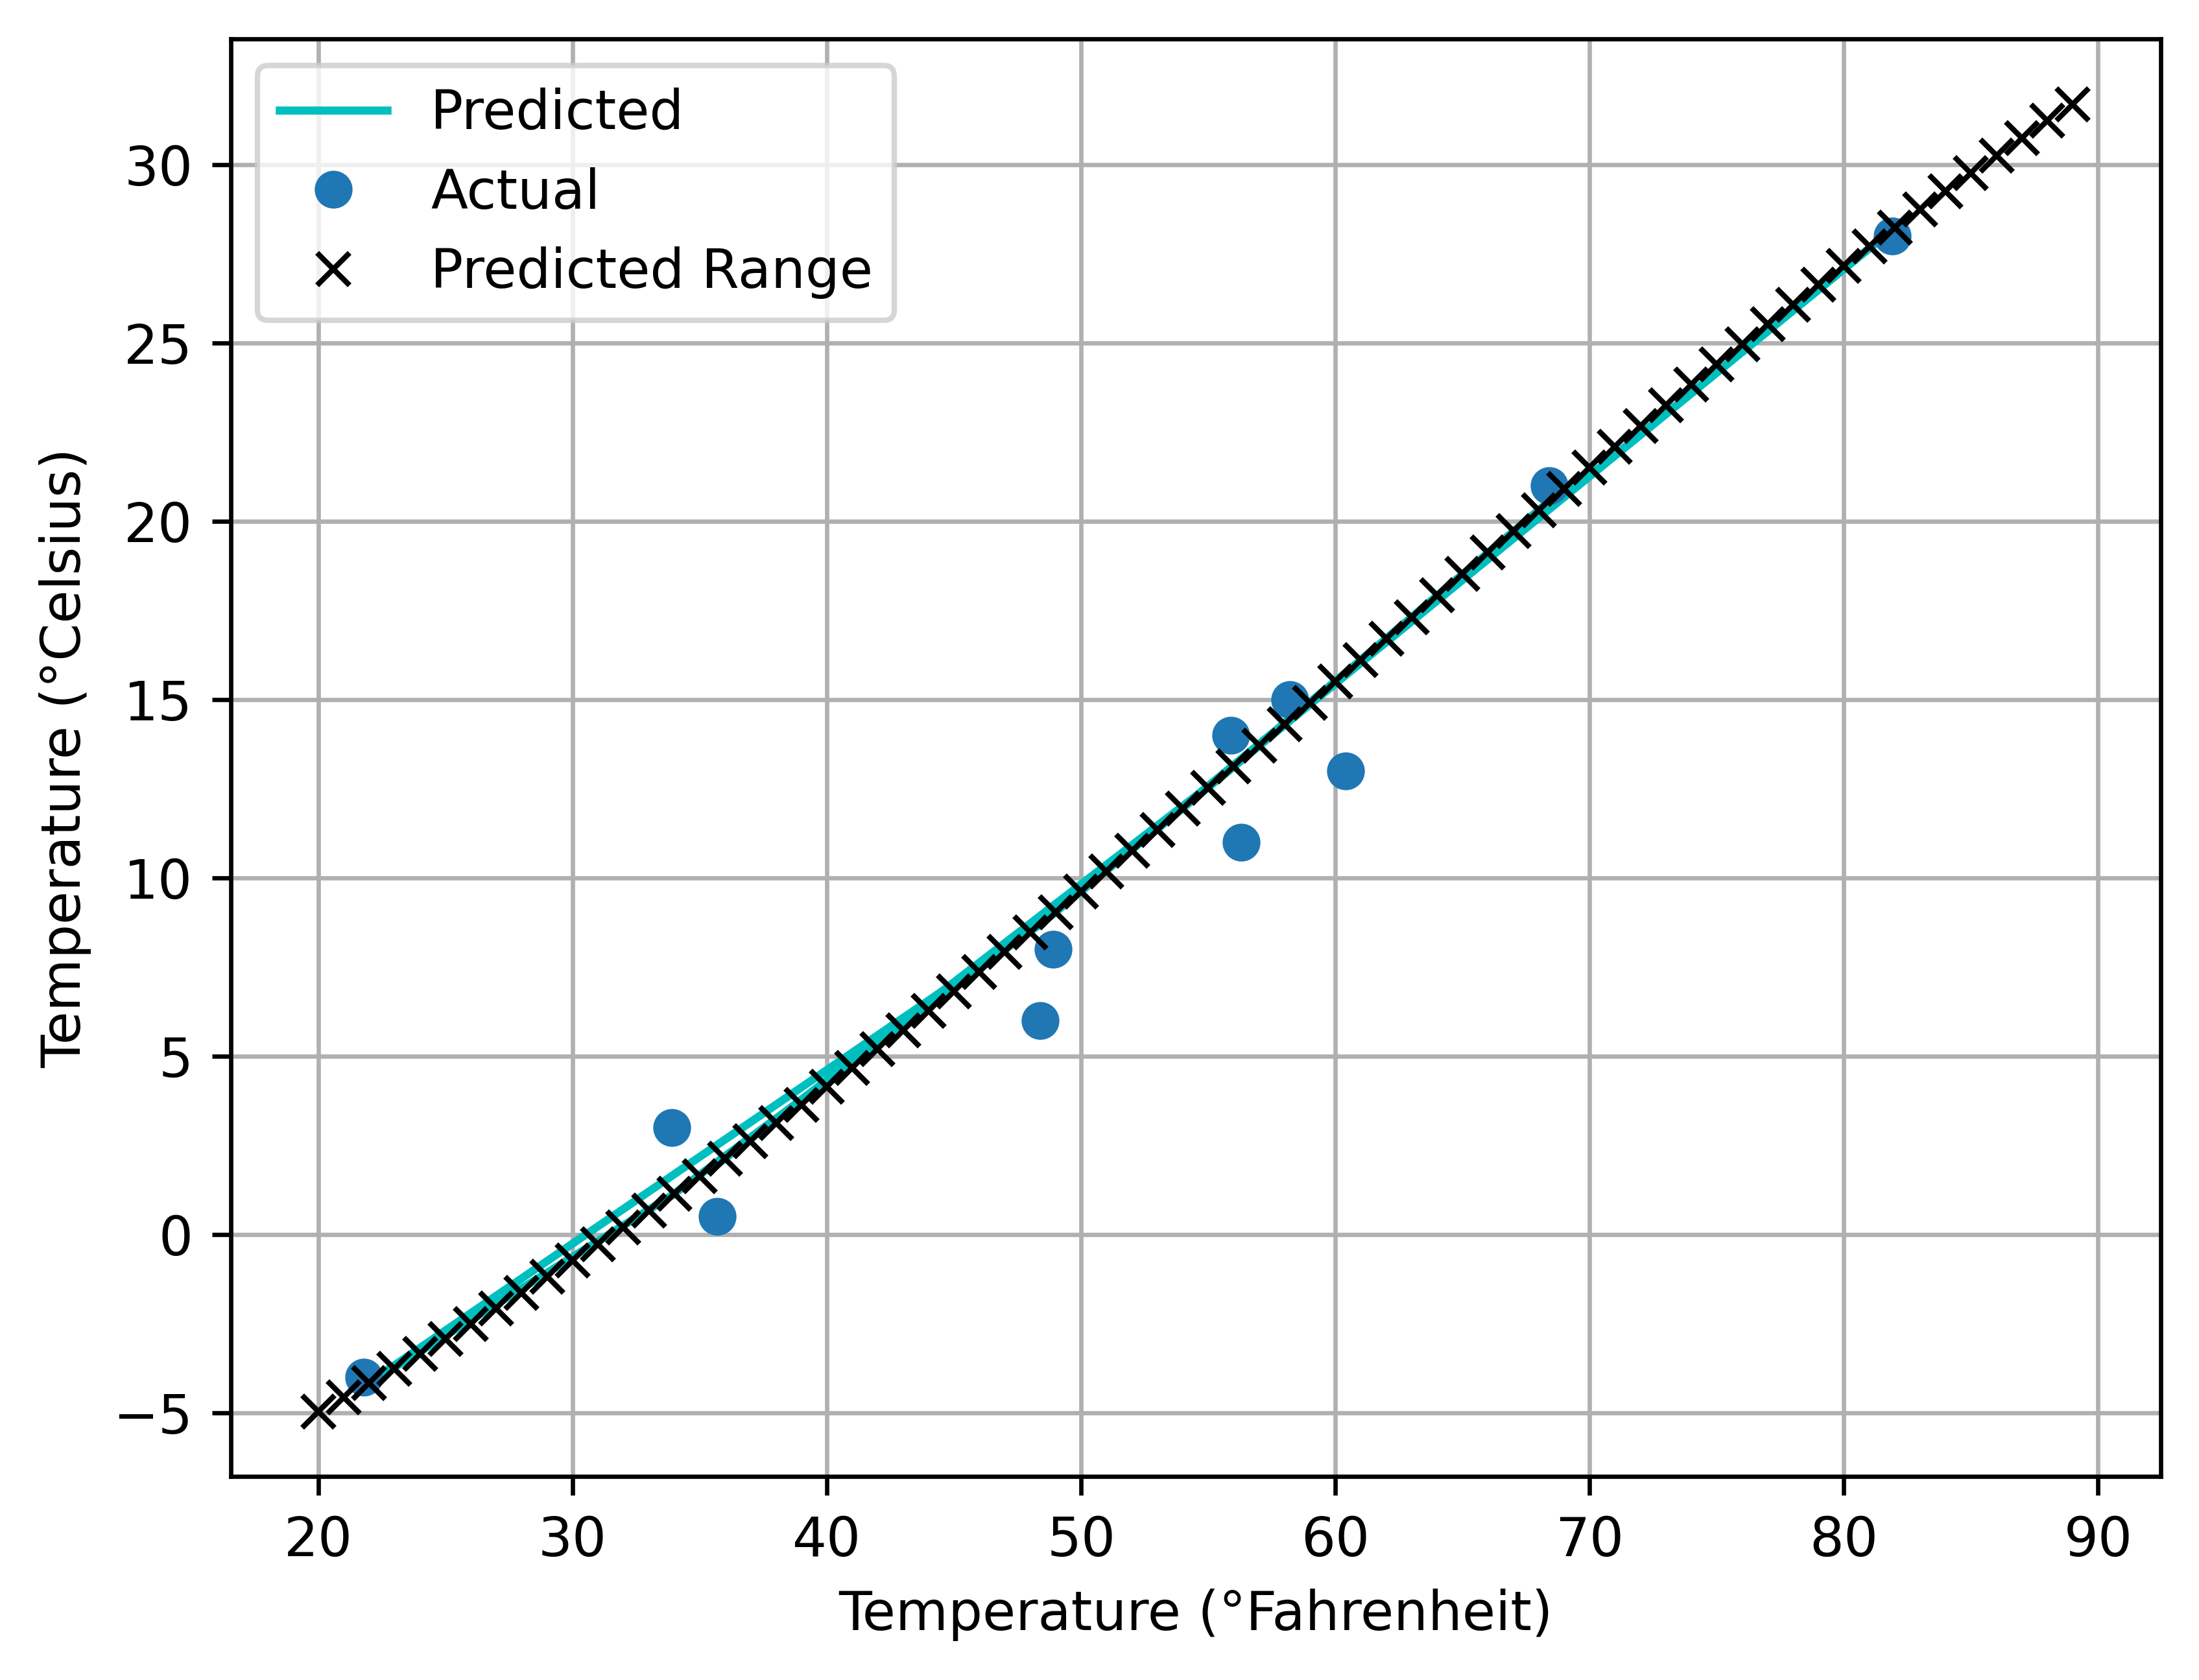

In [11]:
t_p = seq_model(t_u)

#scale back
t_u /= normalization_factor
t_p /= normalization_factor
t_c /= normalization_factor

t_range = torch.arange(20., 90.).unsqueeze(1)
y_range = seq_model(t_range * normalization_factor) / normalization_factor
    
fig = plt.figure(dpi=600)
plt.grid(True)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy(), "c-", label="Predicted")
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label="Actual")
plt.plot(t_range.numpy(), y_range.detach().numpy(), 'kx', label="Predicted Range")
plt.legend()
plt.show()